In [1]:
#Import required libraries
import simpy
import numpy as np
import pandas as pd
import random

In [2]:
#set seed and simulation time
seed = 50
simulation_time = 8 #Bank operational hours

In [3]:
np.random.seed(seed)
#Report here is being generated as a global variable
report = pd.DataFrame(columns = ['Customer Id', 'Service', 'Arrival Time', 'Floor Time', 'Service Start Time', 'Service Stop Time'])

In [4]:
#Function to generate arrival, 5 to 10 customers per 60 mins
def customer_arrival(): #Arrival rate 1 - 20 per hour
    return np.random.exponential(15.0/np.random.randint(2,6))

In [5]:
# Setting time it takes for a customer to meet with floor person   
def meet_floor_person(self, customer):
    # min of 2 minutes and max of 10 minutes
    yield self.env.timeout(random.randint(2, 11)) 

In [6]:
#Function to return time generated for teller service
def repair_service():
    return np.random.triangular(10,30,60)

In [7]:
#Function to return time generated for foreign exchange servive
def sales_service():
    return np.random.triangular(15,30,60)

In [8]:
#Function to return time generated for foreign exchange servive
def random_service():
    return np.random.triangular(1,3,5)

In [9]:
def bike_shop(env,  repair, sales, random):
    global current_hour
    i = 0 #counter for customer
    while True: #running time 6 hours

        Service = np.random.choice(['Repair', 'Sales', 'Random'], p=[0.80, 0.1, 0.1]) 
        i += 1
        yield env.timeout(customer_arrival())
        env.process(customer(env, i,  repair, sales, random, Service))

In [10]:
#function generates report for each customer
def customer(env, customer, repair, sales, random, Service):
    
    global report #access the global variable

    if Service == 'Sales':
        req = sales
    else:
        req = repair
    
    with sales.request() as request:
        arrival_time = env.now #starts the clock
        yield env.timeout(5) # Token generation time of 30 seconds
        floor_time = env.now #records time at which token is taken
        
        yield request
        service_start_time = env.now #service starts 
        
        if Service == 'Sales':
            yield env.timeout(sales_service())
        else:
            yield env.timeout(repair_service())
        service_stop_time = env.now 
        #record the data generated
        row = pd.DataFrame([['Customer_{}'.format(customer), Service, arrival_time, floor_time, service_start_time, service_stop_time]],
                          columns = ['Customer Id', 'Service', 'Arrival Time', 'Floor Time','Service Start Time', 'Service Stop Time'])
       
        report = report.append(row, ignore_index = True, sort = False)
        #Calculations for wait time
        report['Floor Time (Mins)'] = ( report['Floor Time'] - report['Arrival Time'])
        report['Service Time (Mins)'] =  (report['Service Stop Time'] - report['Service Start Time'])
        report['Wait Time (Mins)'] =  ( report['Service Start Time'] - report['Floor Time'] )


In [11]:
#Running it in a model
def model(nruns, nrepair, nsales, nrandom): 
    
    #Init
    Repair=[] 
    Sales=[]
    Random=[]
    avg_wait_time = []
    sales_wait_time = []
    repair_wait_time = []
    random_wait_time = []
    global report
    for j in range(nruns):
        report = report[0:0]
        env = simpy.Environment()
        env.initial_time = 0
        # resource
        repair = simpy.Resource(env, capacity=nrepair) 
        sales = simpy.Resource(env, capacity=nsales) 
        random = simpy.Resource(env, capacity=nrandom) 
        env.process(bike_shop(env, repair, sales, random))
        env.run(until = 8 * 60) #run for 8 hours
        
        
        Sales=report[report.Service.isin(['Sales'])] #separate to calculate mean later
        Repair=report[report.Service.isin(['Repair'])]
        Random=report[report.Service.isin(['Random'])]
    
        avg_wait=report['Wait Time (Mins)'].mean() #Calculate average time
        avg_wait_repair=Repair['Wait Time (Mins)'].mean()
        avg_wait_sales=Sales['Wait Time (Mins)'].mean()
        avg_wait_random=Random['Wait Time (Mins)'].mean()
    
        avg_wait_time.append(avg_wait)
        sales_wait_time.append(avg_wait_sales)
        repair_wait_time.append(avg_wait_repair)
        random_wait_time.append(avg_wait_random)
        
    #Save in a dataframe
    new_dict = {"avg_wait": avg_wait_time, "sales_wait": sales_wait_time, "repair_wait": repair_wait_time, "random_wait": random_wait_time }
    
    global new_df
    new_df = pd.DataFrame(new_dict)
    fig=new_df.boxplot(grid=False, widths=0.8)
    return new_df
    return fig

,avg_wait,sales_wait,repair_wait,random_wait
0,2.537999,1.607024,2.679427,2.372923
1,0.534781,1.149245,0.340381,1.303686
2,1.235856,2.220239,1.197168,0.869611
3,0.606982,1.133831,0.493471,0.911729
4,3.894387,0.480001,4.198186,4.561381
5,1.779356,2.277439,1.909009,0.689690
6,0.243492,0.658079,0.176592,0.318037
7,0.981969,1.644501,0.951231,0.786412
8,0.067797,0.000000,0.051831,0.273508
9,0.195028,0.000000,0.186145,0.605368


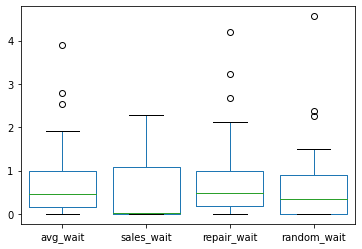

In [12]:
np.random.seed(75)
model(30,25,11,11)

In [13]:
report

,Customer Id,Service,Arrival Time,Floor Time,Service Start Time,Service Stop Time,Floor Time (Mins),Service Time (Mins),Wait Time (Mins)
0,Customer_1,Sales,1.420854,6.420854,6.420854,31.660442,5.0,25.239588,0.0
1,Customer_5,Repair,8.276503,13.276503,13.276503,40.667240,5.0,27.390737,0.0
2,Customer_2,Repair,4.889422,9.889422,9.889422,40.725067,5.0,30.835645,0.0
3,Customer_7,Repair,9.954503,14.954503,14.954503,40.838809,5.0,25.884306,0.0
4,Customer_9,Repair,17.827292,22.827292,22.827292,45.866050,5.0,23.038758,0.0
...,...,...,...,...,...,...,...,...,...
86,Customer_91,Sales,435.982370,440.982370,440.982370,458.022911,5.0,17.040541,0.0
87,Customer_87,Repair,417.883144,422.883144,422.883144,462.025308,5.0,39.142164,0.0
88,Customer_93,Repair,452.238342,457.238342,457.238342,471.288257,5.0,14.049915,0.0
89,Customer_89,Repair,431.169314,436.169314,436.169314,474.380442,5.0,38.211128,0.0
